In [1]:
import numpy as np
import scipy.stats as ss
import elfi

seed = 20180706

In [2]:
# def fun(x, batch_size, random_state):
#     return np.sum(x, keepdims=True, axis=1)

In [3]:
# class CustomPrior_t1(elfi.Distribution):
#     def rvs(b, size=1, random_state=None):
#         m_u = ss.multivariate_normal(mean=[0, 0, 0], cov=[1, 5, 25])
#         rvs = m_u.rvs(size=size, random_state=random_state)
#         return rvs

In [4]:
# # t1 = elfi.Prior(ss.multivariate_normal, [0, 0, 0, 1, 2, 3, 4, 5])
# t1 = elfi.Prior(CustomPrior_t1, 3)
# sim = elfi.Simulator(fun, t1, observed=np.array([[0]]))
# d = elfi.Distance('euclidean', sim)

In [5]:
# elfi.draw(d)

In [6]:
# elfi.Rejection(sim, batch_size=10).sample(10)

### Testing progress bar

In [7]:
import time
from functools import partial

import elfi
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

from elfi.examples.gauss import get_model

import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter

%matplotlib inline
%precision 2
np.random.seed(seed)
N = 1000

In [8]:
m_1d = get_model()

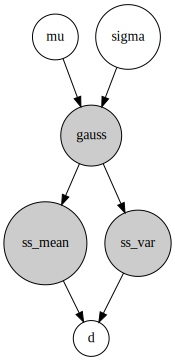

In [9]:
elfi.draw(m_1d['d'])

In [10]:
rej_1d = elfi.Rejection(m_1d['d'], batch_size=N, seed=seed)

In [11]:
result_1d = rej_1d.sample(N)

actual number of iterations infer function  100


In [12]:
result_1d

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 0.167
Sample means: mu: 3.99, sigma: 0.345

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3beca9d710>,
      dtype=object)

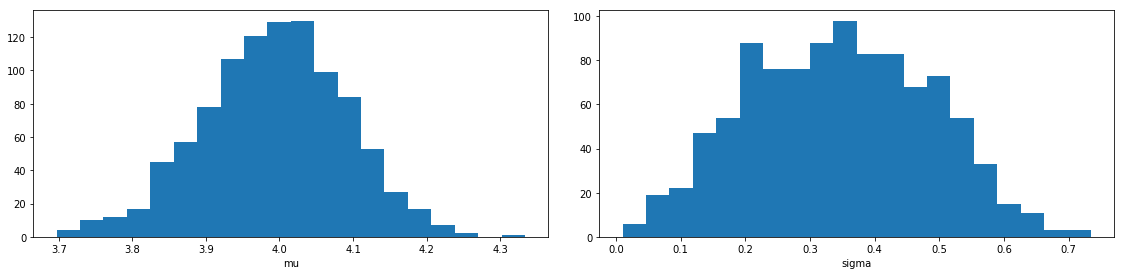

In [13]:
result_1d.plot_marginals()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bec7d48d0>,
      dtype=object)

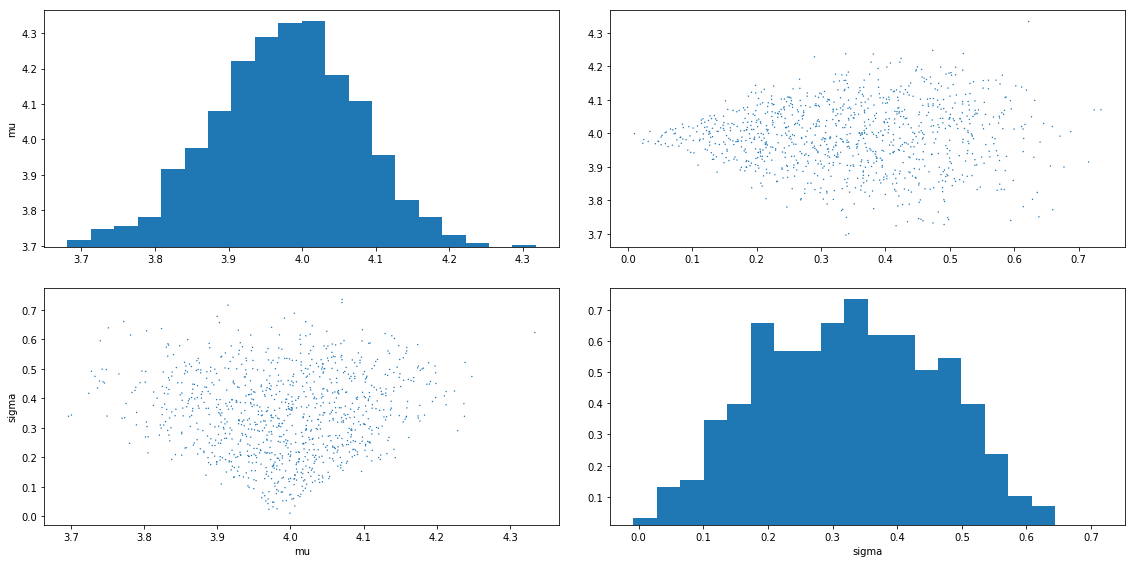

In [14]:
result_1d.plot_pairs()